## Feature Engineering
### Principal Component Analysis on news headlines embeddings 

#### Overview

One of the fundamental stages of a successful Artificial Intelligence (AI) solution is feature engineering.  The goal of the process is maximization of the AI predictive power by transforming the raw data in an effort to provide high insight designed feature sets.

In AI models, we are often confronted by high-dimensional data and features. Generally, a big feature space is considered positive. However, sometimes as dimensionality increases, the volume space increases so fast giving rise to multiple problem. One such is that the available data can become sparse. This causes machine learning models to be less effective and will result in an exponential increase in computational complexity. This issue is referred to as the "curse" of dimensionality and can be tackled by dimensionality reduction techniques. The idea behind dimensionality reduction is trying to represent the variance of the data space with fewer variables while preserving as much of the existing structure in the data as possible. This can be accomplished by keeping existing or creating new features with high separability and variance.

One very common technique for dimensionality reduction is Principal Component Analysis (PCA) which helps us uncover the underlying drivers hidden in our data by summarising huge feature sets into a few principal components.

This guide will use PCA as a practical tool for reducing the dimension of feature embeddings from news headlines derived from [LSEG Lab's](https://www.lseg.com/about-lseg/labs) [BERT-RNA](https://www.lseg.com/about-lseg/labs/financial-language-modelling), a financial language model created by [LSEG Labs](https://www.lseg.com/about-lseg/labs). We will show how PCA can impact the performance of the ML model. We will also discuss several approaches for selecting the optimal number of principal components.

#### About PCA

The goal of PCA is to extract the most important information from the feature space using transformations (rotations) on the features base coordinate space. After the rotations the principal components, in the sense of variance explanation, of the feature space are isolated for further analysis. This in turn leads to compression since the less important information is discarded. When it comes to the technical implementation of PCA, it looks for dimensions with the greatest variance in the dataset using eigenvectors and eigenvalues. In order to find the eigenvector, a vector is multiplied by a covariance matrix as a result of which the original vector will rotate to the direction of the highest variance. Once the direction is defined the vector stops turning and changes its scale. That vector then is an Eigenvector. The scale is determined by the eigenvalue. So in PCA, principal components are the eigenvectors with the largest eigenvalues.

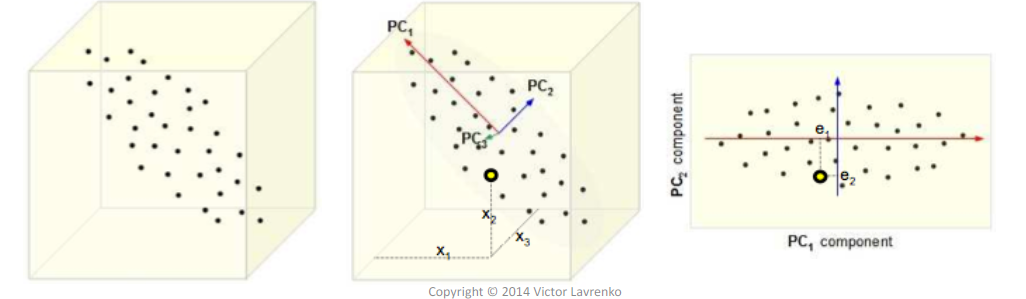

The figure above illustrates the conversion of a 3-dimensional feature space into 2-dimensional space. Further in this guide, we will apply this principle to convert 768-dimensional feature space into a much smaller number of principal components and instead of the initial features will use those components for ML model training and evaluation.

#### Importing required modules

We start by importing the necessary Python for this guide, including PCA, logistic regression, and evaluation metrics from sklearn as well as pandas, numPy, and matplotlib for analyzing and visualizing outputs.

In [ ]:
!pip install matplotlib

In [ ]:
!pip install sklearn

In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib as mp
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import time

#### Describing the dataset

In this guide, we will be using the [Financial PhraseBook dataset](https://www.researchgate.net/publication/251231364_FinancialPhraseBank-v10) by Malo et al. which consists of 4845 news headlines carefully labeled by 16 experts and M.Sc. students with financial services backgrounds. Furthermore, we will be using LSEG Lab's financial language modeling tools to get feature embeddings of those headlines. LSEG's Lab BERT-RNA extends BERT-BASE and creates a finance-domain-specific model leveraging LSEG’s depth and breadth of unstructured financial data. The model is pre-trained using the Reuters News Archive, which consists of all Reuters articles published between 1996 and 2019.
 
Let's first read the Financial Phrasebook dataset and replace the string labels with numerical ones.

In [6]:
# read financial phrasebook dataset into a csv
input_df = pd.read_csv('datasets/Sentences_50Agree.txt', engine='python', sep=".@", header=None, encoding="ISO-8859-1", names=['text','label'])

#update the labels
input_df['label'].replace('positive', 0, inplace =True)
input_df['label'].replace('negative', 1, inplace =True)
input_df['label'].replace('neutral', 2, inplace =True)
input_df

,text,label
0,"According to Gran , the company has no plans t...",2
1,Technopolis plans to develop in stages an area...,2
2,The international electronic industry company ...,1
3,With the new production plant the company woul...,0
4,According to the company 's updated strategy f...,0
...,...,...
4841,LONDON MarketWatch -- Share prices ended lower...,1
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,2
4843,Operating profit fell to EUR 35.4 mn from EUR ...,1
4844,Net sales of the Paper segment decreased to EU...,1


The next step is to format our data into the CSV structure that BERT RNA expects, a CSV structure with a single column for the text. We then upload the CSV file into the Labs environment by creating a new Job as shown below.

Then I upload the CSV file into the [Labs environment](https://flm.labs.refinitiv.com/) by creating a new Job.

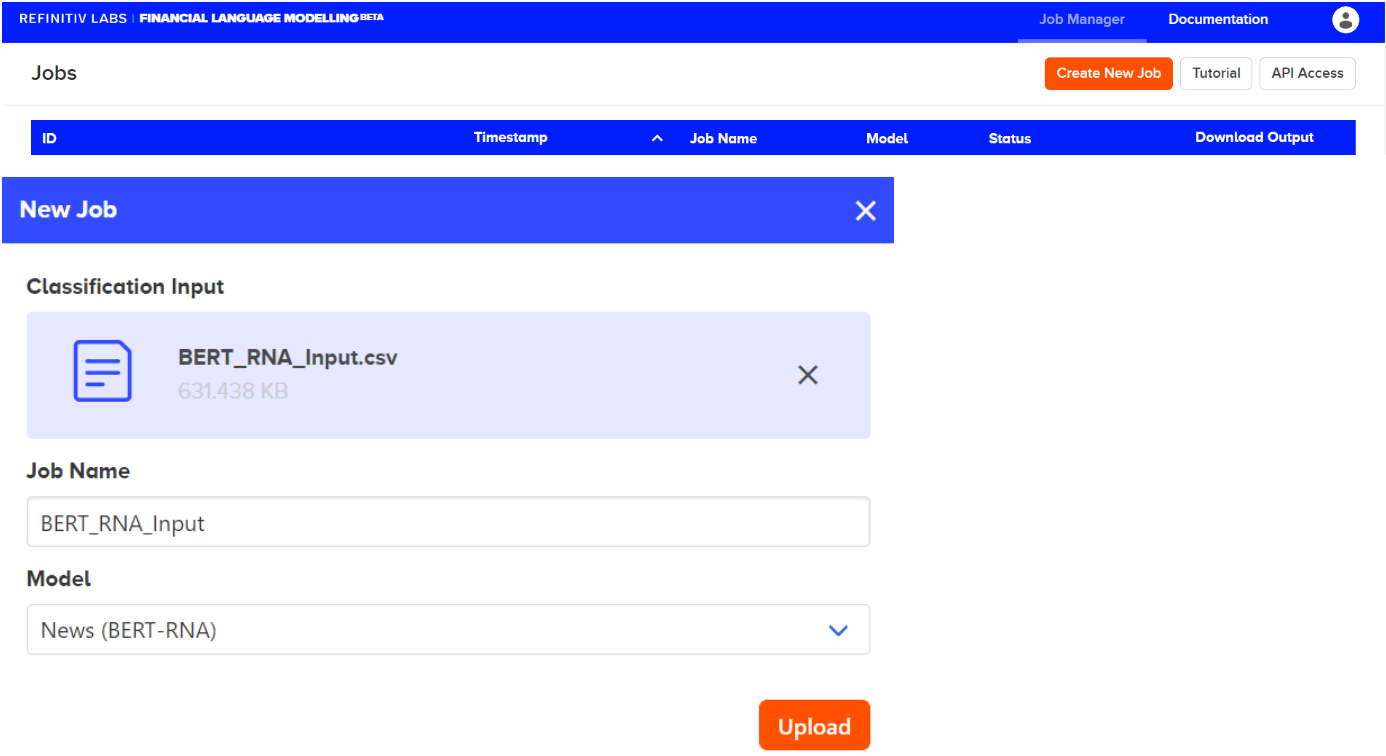

After the job finishes, an OUT file is created, which can be downloaded from the Labs environment.

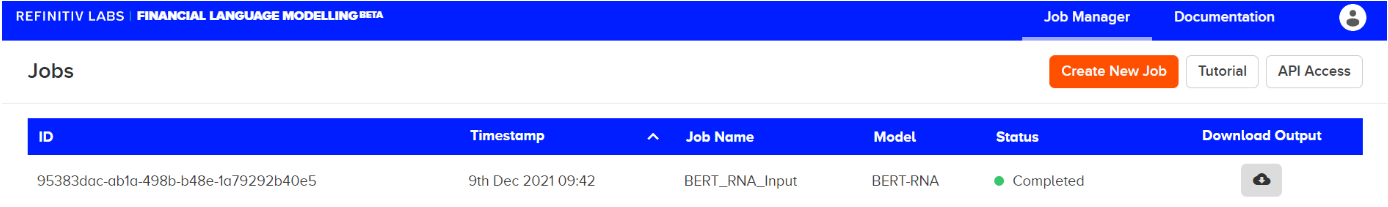

Finally, we can ingest the out file back to our environment by pandas read_json function.

In [7]:
# read embeddings from .out file exported from the Labs UI 
X = pd.read_json('datasets/data_phrasebook.out')
y = input_df['label']
X

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.205987,-0.972051,-0.381347,0.501484,0.447768,-0.110406,-0.234994,0.848129,0.360031,-0.292546,...,0.913734,-1.026575,-0.905293,-0.347511,0.355931,-0.314400,-0.214688,1.274410,0.453175,-0.341905
1,-0.113231,-0.301700,0.002256,0.194796,-0.718617,-0.341368,-1.007442,0.307653,0.209102,0.985369,...,0.483089,-0.847685,-1.057852,-1.417513,0.238430,0.241687,0.104607,1.550795,1.130612,-0.348374
2,-0.684828,-0.622877,-0.286472,0.148611,0.217178,-0.284424,-0.645603,0.768584,0.321413,0.908583,...,0.541181,-0.685226,-1.008933,-0.682811,-0.057627,0.381497,0.292033,1.189711,1.192648,-0.445462
3,-0.904132,0.030845,0.622767,0.262248,0.077298,-0.140442,-0.579286,0.101153,0.377318,0.261287,...,0.568160,-0.969471,-0.711470,-0.391669,0.507979,-0.210143,0.211704,1.644572,0.787941,-0.044877
4,-0.670881,-0.279356,0.123999,0.624517,-0.294081,0.547578,-0.694566,-0.116304,0.309266,0.085417,...,-0.285442,-2.091228,-1.278206,-0.919836,0.679970,-0.128099,-0.331344,2.467715,1.429780,-0.408402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4841,0.291847,-0.368403,-0.075330,-0.475089,0.090659,0.018811,-1.438870,0.128115,0.370175,0.261961,...,0.350524,-0.523013,-0.403692,-0.361895,0.065908,-0.348491,-0.100785,0.583923,0.167371,0.114616
4842,-0.426211,0.209680,0.656362,0.021192,-0.444328,0.345237,-0.065663,0.130673,0.348777,-0.764620,...,0.778103,-0.687950,-0.825206,-1.186906,0.282052,0.543752,-0.508156,0.896873,1.520246,0.220932
4843,-0.585969,-0.129938,-0.285298,0.775940,-0.133086,0.211291,-0.996838,-0.268328,0.264023,-0.151466,...,0.609232,-0.993658,-0.438280,-0.746995,0.121187,0.543687,-0.187304,2.146530,0.865253,-0.689822
4844,-0.437853,0.091371,-0.080444,0.312875,0.044210,0.556767,-0.824997,-0.315556,0.251787,-0.021879,...,0.800655,-1.251211,-0.662396,-0.551048,0.042943,0.248919,-0.335846,2.259034,0.926028,-0.810402


We can see from the above dataframe  that we have 768 dimensions in the dataset. This is the default output of BERT models no matter the initial length of the provided input text. Additionally, BERT RNA is trained with a max sentence length set as 512 tokens and if the average length of text input is much less than that, the feature space can become very sparse. As the news headlines have much shorter sentence lengths it is recommended to apply dimensionality reduction for which we will be using PCA.
 
An important decision factor in the process is how many principal components we need to select in order to preserve as much of the initial dataset predictive value.

#### Selecting the optimal number of principal components

Multiple approaches exist for selecting the optimal dimensionality, starting from NLP approaches based on the average or maximum length of text input to explained variance of principal components using Root Mean Square Error (RMSE).
 
A basic approach would be to calculate the average sentence length and use that as a number of components for PCA. Let's calculate both the average and the maximum text length and consider using those numbers as an optimal size of the dimension.

In [8]:
# get average length of sentences for finding the optimal number of PCA components
length = []
for i in range(len(input_df)):
    length.append(len(input_df['text'][i]))
print(f'Average length of the text input is {round(np.mean(length),0)}')
print(f'Maximum length of the text input is {round(np.max(length),0)}')
print(f'Standard deviation in length of the text input is {round(np.std(length),0)}')

Average length of the text input is 127.0
Maximum length of the text input is 314
Standard deviation in length of the text input is 57.0


We can see above that the average length of the headlines is 127 characters with a standard deviation of 57 and a maximum value of 314 characters. With such high standard deviation in the length of sentences, applying PCA with components equaling to the average sentence length might not produce robust and accurate results. We need to use more sophisticated techniques for identifying the optimal number of principal components.

Such a technique for selecting the optimal number of principal components is to plot the cumulative Variance graph and look for the number of components where at least 95% of the variance is covered. But before plotting let's apply the PCA with 127 components and print the first 50 outputs to see how the variance explained by each component changes.

In [9]:
#(1) Your code goes here
pca_127 = PCA(n_components = 127).fit(X.to_numpy())
print('Variance of first 50 principal components is', np.around(pca_127.explained_variance_,2)[:50])

Variance of first 50 principal components is [27.82 10.48  6.27  5.21  4.85  3.88  3.67  3.04  2.57  2.45  2.36  2.23
  2.06  1.89  1.76  1.64  1.62  1.6   1.52  1.43  1.37  1.3   1.26  1.24
  1.21  1.17  1.12  1.1   1.07  1.01  0.99  0.96  0.95  0.92  0.89  0.85
  0.84  0.8   0.79  0.76  0.73  0.73  0.72  0.68  0.67  0.66  0.64  0.62
  0.61  0.61]


We can see that the explained variance of the first component is 27.82 and thereafter it decreases radically from component to component reaching 0.61 in the 50th component. This suggests that a much smaller number of components will be able to explain the enough of the dataset variance. Furthermore, let's plot cumulative variance to find the threshold where 95% of the variance is explained.

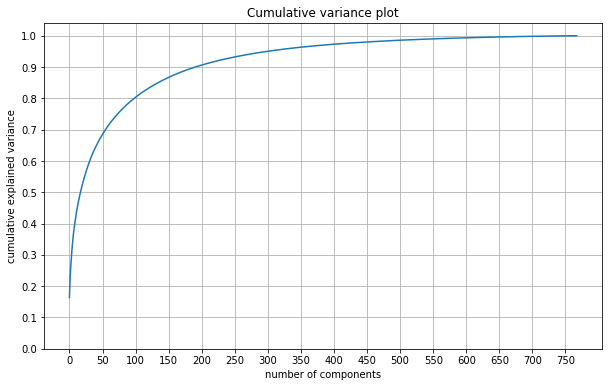

In [10]:
pca_768 = PCA(n_components=768).fit(X.to_numpy())
var_ratio = pca_768.explained_variance_ratio_

plt.figure(figsize=(10,6))
plt.plot(np.cumsum(var_ratio))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Cumulative variance plot')
plt.yticks(np.arange(0,1.1, 0.1))
plt.xticks(np.arange(0,800, 50))
plt.grid()

From the plot above we see thath the explained variance is increasing very quickly in between the first 50-100 components then it smooths out reaching 95% explainability at the 300 principal component. The following code snippet outputs the number of components and their different explained variance thresholds so we can accurately identify the cut-off point.

In [11]:
#(3) Your code goes here
req_var = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

for var in req_var:
    c = 0
    i = -1
    while c <= var:
        i += 1
        c = c + var_ratio[i]
    print('Number of components to explain', '{:.0f}%'.format(var*100), 'of variance is', '{}'.format(i+1))

Number of components to explain 50% of variance is 18
Number of components to explain 60% of variance is 32
Number of components to explain 70% of variance is 56
Number of components to explain 80% of variance is 99
Number of components to explain 90% of variance is 192
Number of components to explain 95% of variance is 300
Number of components to explain 99% of variance is 551


From the analysis above we can conclude that the optimal number of principal components to use for dimensionality reduction is 300 since it explains 95% of the variance. Additionally, it is worth computing and plotting RMSE to explore how that changes as we are using more components.

In [ ]:
pca_comps = np.arange(0,750, 50)
rmse_vals = []
for component in pca_comps:
    pca_nm = PCA(n_components=component)
    pca_nm.fit(X.to_numpy())
    X_trans = pca_nm.transform(X.to_numpy()[0].reshape(1, -1))
    recon = pca_nm.inverse_transform(X_trans)
    rmse = mean_squared_error(X.to_numpy()[0], recon[0],squared=False)
    rmse_vals.append(rmse)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(pca_comps, rmse_vals)
plt.xlabel('number of components')
plt.ylabel('RMSE')
plt.title('RMSE plot')
plt.xticks(np.arange(0,800, 50))
plt.grid()

The results of the RMSE plot are in line with our findings from the cumulative variance plot as the steepest decline in RMSE is witnessed between components 300 and 350.
 
Identifying the optimal number of principal components and applying PCA prior to model evaluation, does not guarantee optimal results on the next steps of the pipeline. That said, further analysis needs to be conducted during the modelling and evaluation phase. Depending on the context, there exist numerous validation methodologies and performance metrics to further strengthen confidence on the value of the AI pipeline. For example, in the case of supervised learning models, results validation is conducted by measuring performance metrics such as accuracy, precision, recall, AUC, etc. For unsupervised learning techniques, such as PCA, results validation sometimes is not that straightforward. The literature mainly suggests two methodologies for evaluating unsupervised tasks, internal and external validations. The internal validation is mostly applicable to clustering models. PCA results can be validated using the external validation approach. That can be done by measuring the impact of using different numbers of principal components on the final task, hence measuring the impact on the performance of the AI model.

#### Impact of PCA on predictive power of the model and the training time

In order to have an initial measurement the impact of dimensionality reduction of news headline embeddings through PCA, we train multiple logistic regression models using a  liblinear solver and default parameters on the headlines using different numbers of principal components of the feature space. Another interesting aspect of this blueprint is computational complexity and how that is affected from dimensionality reduction. We track training time for each model and plot the time along with the training and test accuracies. This will allow us to better understand the impact of dimensionality reduction with regards to computational demand of the models.

In [27]:
pca_comps = [5, 10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 768]
test_accuracy = []
train_accuracy = []
times = []

for component in pca_comps:
    pca = PCA(n_components = component)
    output_pca = pca.fit_transform(X.to_numpy())
    X_train_pca,X_test_pca,y_train_pca,y_test_pca = train_test_split(pd.DataFrame(output_pca), y, test_size = 0.20, random_state=0)
    
    start = time.time()
    logistic_regression_pca = LogisticRegression(solver='liblinear').fit(X_train_pca,y_train_pca)
    end = time.time()

    acc_test = logistic_regression_pca.score(X_test_pca, y_test_pca)
    acc_train = logistic_regression_pca.score(X_train_pca, y_train_pca)
    
    test_accuracy.append(acc_test)
    train_accuracy.append(acc_train)
    times.append(end-start)

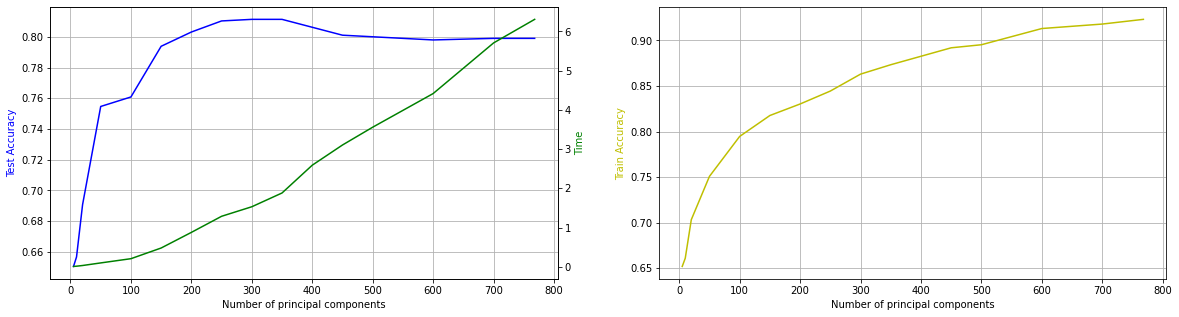

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax3 = ax1.twinx()

ax1.plot(pca_comps, test_accuracy, 'b-')
ax3.plot(pca_comps, times, 'g-')
ax2.plot(pca_comps, train_accuracy, 'y-')

ax1.set_xlabel('Number of principal components')
ax2.set_xlabel('Number of principal components')
ax1.set_ylabel('Test Accuracy', color='b')
ax2.set_ylabel('Train Accuracy', color='y')
ax3.set_ylabel('Time', color='g')
ax1.grid()
ax2.grid()
plt.show()

It can be inferred from the plot above that the maximum accuracy is achieved when using 300-350 principal components for the model training. Furthermore, as we increase the number of principal components the overall accuracy of the logistic regression model is decreasing. A possible explanation for that is that a larger number of features results in the addition of excess noise and/or overfitting. The presence of overfitting, results in lowered generalization AI which in turn leads to degraded performance in out-of-sample testing. This analysis further supports the thought process that applying dimensionality reduction helps reduce noise in our initial dataset and achieve better AI generalisation and higher predictive power. 
 
Additionally, another important benefit of the methodology is clearly revealedthrough the plots, decrease in the computational time and complexity. This is a very important constituent, especially for more sophisticated AI models with much larger datasets that enter the Big Data space.

#### Conclusions

In this guide, we introduced PCA as a feature engineering technique and discussed the impact of dimensionality reduction on the performance of a logistic regression model trained on embeddings from news headlines. Additionally, we applied and discussed several approaches for identifying the optimal number of principal components. Finally, we analyzed how the accuracy of the model and training times change when training AI with different numbers of principal components.